# Imoprts

In [34]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modify sys.path 
project_root = '/Users/carlesferreres/Desktop/Carles/Empresas/KOA/Repos/aquagen-experimentation/'
os.chdir(project_root)

from src.utils.google_drive import GoogleDrive

# Config

In [35]:
EXPERIMENT_CONFIG_PATH = os.getenv('EXPERIMENT_CONFIG_PATH')
with open(EXPERIMENT_CONFIG_PATH) as json_file:
    exp_config = json.load(json_file)

i_folder_id = exp_config.get('data').get('source').get('folder_id')
i_filename = exp_config.get('data').get('source').get('filename')
o_folder_id = exp_config.get('data').get('output').get('folder_id')
o_filename = exp_config.get('data').get('output').get('filename')
first_date = exp_config.get('training').get('first_date')

# Process data

In [36]:
# Load data
gdw = GoogleDrive()
file = gdw.read_file(i_folder_id, i_filename)
df = pd.read_excel(file, engine='openpyxl')

In [37]:
# Transform dates
df['ExperimentDate'] = df.ExperimentDate.str[:10]
df['ExperimentDate'] = pd.to_datetime(df['ExperimentDate'])

In [38]:
# Filter valid samples and fix data
df = df[df.ExperimentDate >= pd.to_datetime(first_date)]
df = df[df.InputType == 'Pathogen']
df['Concentration'].fillna(-1, inplace=True)
df['Concentration'] = df.Concentration.astype(int)
df['InputName'] = df.InputName.str.lower()

/var/folders/z3/2c25rb6n7s34bm0ghpnhmz6m0000gn/T/ipykernel_5252/840200647.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Concentration'].fillna(-1, inplace=True)


In [39]:
# Group by experiment type
summary = df.groupby(['InputName', 'Concentration'])['InputName'].size().reset_index(name='Count')
summary['InputNameTotal'] = summary.groupby('InputName')['Count'].transform('sum')
summary

,InputName,Concentration,Count,InputNameTotal
0,ahydrophila,1000,12,116
1,ahydrophila,10000,24,116
2,ahydrophila,100000,12,116
3,ahydrophila,500000,32,116
4,ahydrophila,10000000,36,116
5,asalmonicida,10000,30,60
6,asalmonicida,100000,30,60
7,control,-1,148,194
8,control,0,46,194
9,pdpiscicida,10000,24,80


Text(0.5, 1.0, 'Experiment Summary Heatmap')

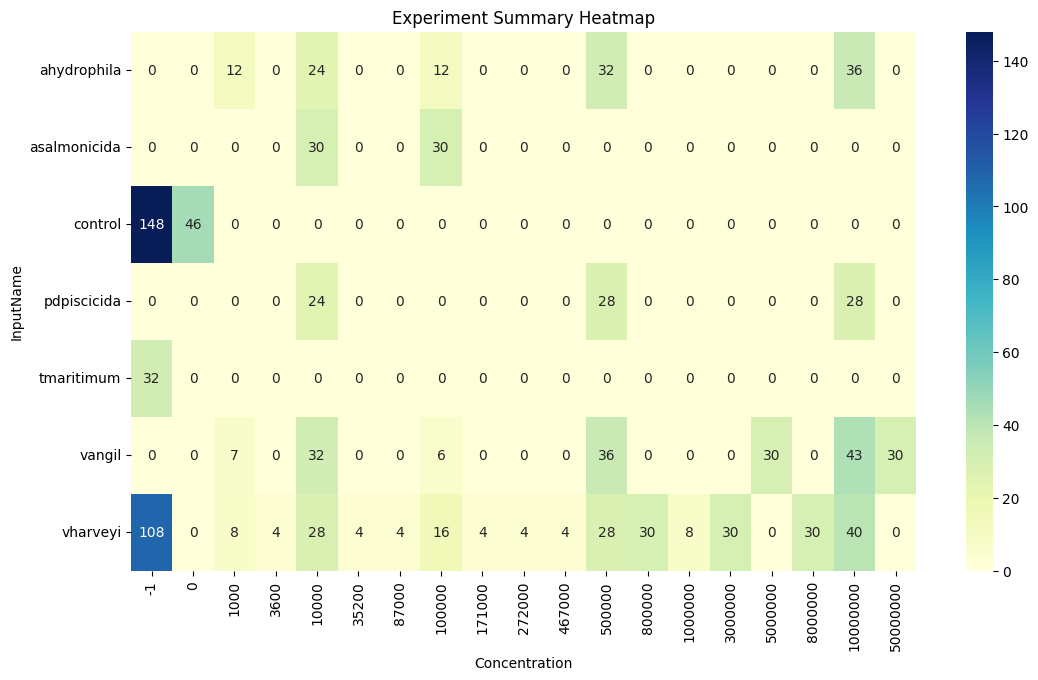

In [40]:
# Create heatmap
pivot_summary = summary.pivot(index='InputName', columns='Concentration', values='Count')
pivot_summary.fillna(0, inplace=True)
pivot_summary = pivot_summary.astype(int)
fig, ax = plt.subplots(figsize=(len(pivot_summary.columns)/1.5, len(pivot_summary))) 
sns.heatmap(pivot_summary, annot=True, fmt=".0f", cmap='YlGnBu', ax=ax) 
plt.title("Experiment Summary Heatmap")

# Wrtie files

In [41]:
# Upload heatmap to Google Drive
img_filename = o_filename + '.jpg'
done = gdw.write_file(fig, o_folder_id, img_filename)
if done:
    print('Experiment image uploaded to Google Drive')

Experiment image uploaded to Google Drive


In [42]:
# Write Excel to Google Drive
xlsx_filename = o_filename + '.xlsx'
done = gdw.write_file(summary, o_folder_id, xlsx_filename)
if done:
    print('Experiment Excel uploaded to Google Drive')

Experiment Excel uploaded to Google Drive
